#British Airways Flight Booking - Model Building & Evaluation

> Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

import xgboost as xgb
import lightgbm as lgb

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

> Load the featured dataset

In [2]:
df = pd.read_csv('data/customer_booking_featured.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nTarget Distribution:")
print(df['booking_complete'].value_counts())
print(f"\nTarget Distribution (%):")
print(df['booking_complete'].value_counts(normalize=True) * 100)

# Check for any missing values
print(f"\nMissing Values: {df.isnull().sum().sum()}")

df.head()

Dataset Shape: (49281, 32)

Target Distribution:
booking_complete
0    41890
1     7391
Name: count, dtype: int64

Target Distribution (%):
booking_complete
0    85.002334
1    14.997666
Name: proportion, dtype: float64

Missing Values: 0


,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,flight_duration,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,is_weekend_flight,...,is_popular_route,passengers_per_day,planning_ratio,duration_per_passenger,last_minute_complex,sales_channel_encoded,trip_type_encoded,booking_urgency_encoded,flight_time_category_encoded,booking_complete
0,2,262,19,7,6,5.52,1,0,0,1,...,0,0.100000,13.100000,2.76,0,0,2,4,2,0
1,1,112,20,3,6,5.52,0,0,0,1,...,0,0.047619,5.333333,5.52,0,0,2,1,3,0
2,2,243,22,17,3,5.52,1,1,0,0,...,0,0.086957,10.565217,2.76,0,0,2,4,1,0
3,1,96,31,4,6,5.52,0,0,1,1,...,0,0.031250,3.000000,5.52,0,0,2,1,3,0
4,2,68,22,15,3,5.52,1,0,1,0,...,0,0.086957,2.956522,2.76,0,0,2,2,0,0


## Prepare Data for Modeling

> Separate features and target

In [3]:
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

print(f"Features Shape: {X.shape}")
print(f"Target Shape: {y.shape}")
print(f"\nNumber of Features: {X.shape[1]}")
print(f"\nClass Distribution:")
print(f"Class 0 (Not Complete): {(y==0).sum()} ({(y==0).sum()/len(y)*100:.2f}%)")
print(f"Class 1 (Complete): {(y==1).sum()} ({(y==1).sum()/len(y)*100:.2f}%)")

Features Shape: (49281, 31)
Target Shape: (49281,)

Number of Features: 31

Class Distribution:
Class 0 (Not Complete): 41890 (85.00%)
Class 1 (Complete): 7391 (15.00%)


> Split the data (80% train, 20% test)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training Set Size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test Set Size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTrain Set - Class Distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest Set - Class Distribution:")
print(y_test.value_counts(normalize=True))

Training Set Size: 39424 (80.0%)
Test Set Size: 9857 (20.0%)

Train Set - Class Distribution:
booking_complete
0    0.850015
1    0.149985
Name: proportion, dtype: float64

Test Set - Class Distribution:
booking_complete
0    0.850056
1    0.149944
Name: proportion, dtype: float64


>  Scale features for Logistic Regression

In [5]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Features scaled using StandardScaler")
print(f"  Mean after scaling: {X_train_scaled.mean():.6f}")
print(f"  Std after scaling: {X_train_scaled.std():.6f}")

# Save scaler for future use

with open('model/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("\n Scaler saved as 'scaler.pkl'")

 Features scaled using StandardScaler
  Mean after scaling: 0.000000
  Std after scaling: 1.000000

 Scaler saved as 'scaler.pkl'


##  Model Training

> Training Logistic Regression

In [6]:
lr_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=2000,class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression trained successfully")

Logistic Regression trained successfully


> Training Random Forest

In [7]:
rf_model = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print(" Random Forest trained successfully")

 Random Forest trained successfully


> Training XGBoost

In [8]:
scale_pos_weight= (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print(" XGBoost trained successfully")


 XGBoost trained successfully


> Training LightGBM

In [9]:
scale_pos_weight= (y_train == 0).sum() / (y_train == 1).sum()
lgb_model = lgb.LGBMClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

# Predictions
y_pred_lgb = lgb_model.predict(X_test)
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

print(" LightGBM trained successfully")


 LightGBM trained successfully


## Performance Metrics Summary

In [10]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
  metrics = {
      'Model': model_name,
      'Accuracy': accuracy_score(y_true, y_pred),
      'Precision': precision_score(y_true, y_pred),
      'Recall': recall_score(y_true, y_pred),
      'F1-Score': f1_score(y_true, y_pred),
      'ROC-AUC': roc_auc_score(y_true, y_pred_proba)
  }
  return metrics


> Evaluate all models

In [11]:
results = []

results.append(evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, 'Logistic Regression'))
results.append(evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, 'Random Forest'))
results.append(evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb, 'XGBoost'))
results.append(evaluate_model(y_test, y_pred_lgb, y_pred_proba_lgb, 'LightGBM'))

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.round(4)

print(results_df.to_string(index=False))


# Find best model
best_model_idx = results_df['ROC-AUC'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_roc_auc = results_df.loc[best_model_idx, 'ROC-AUC']

print(f"\n Best Model: {best_model_name} (ROC-AUC: {best_roc_auc:.4f})")


              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.6111     0.2280  0.6678    0.3399   0.6812
      Random Forest    0.7708     0.3077  0.4229    0.3562   0.7100
            XGBoost    0.7039     0.2855  0.6488    0.3965   0.7389
           LightGBM    0.6859     0.2763  0.6759    0.3922   0.7434

 Best Model: LightGBM (ROC-AUC: 0.7434)


- We got LightGBM as best model, with good recall value and ROC-AUC.

##Visualize Model Comparison

> Plot metrics comparison

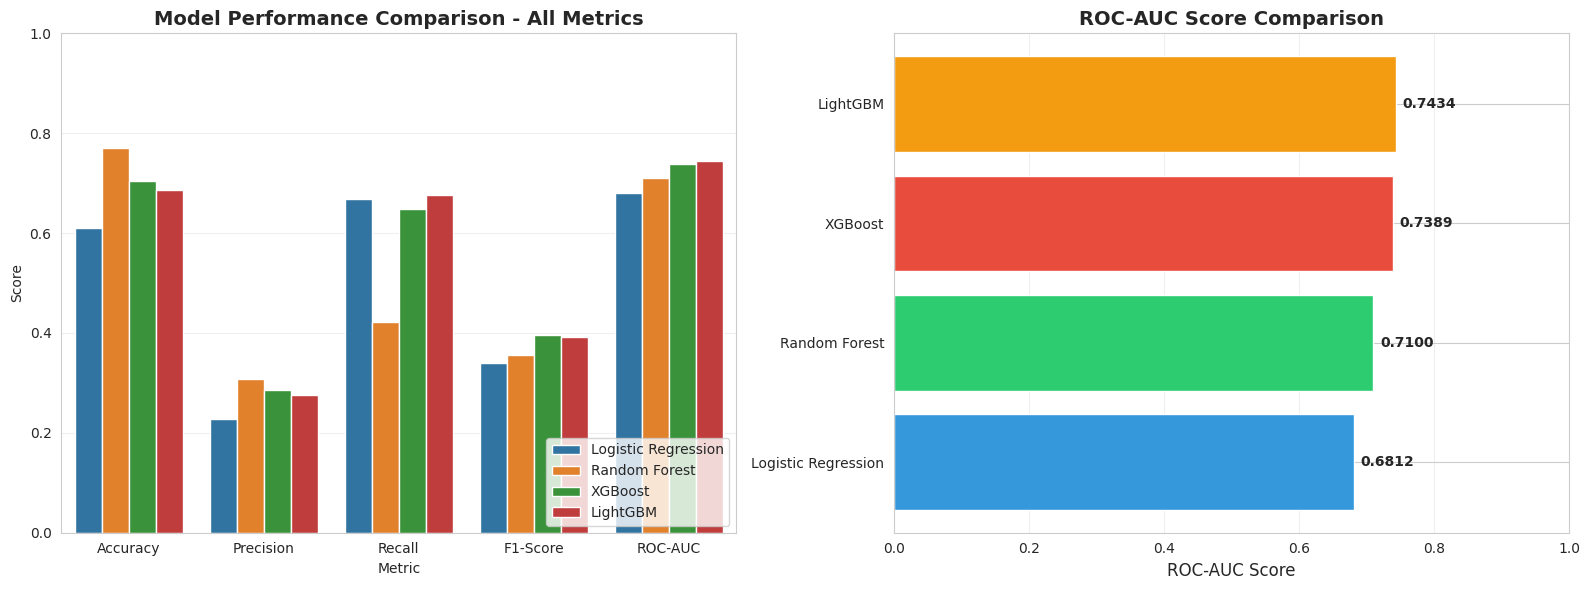

<Figure size 1200x600 with 0 Axes>

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: All metrics

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
results_df_melted = results_df.melt(id_vars=['Model'], value_vars=metrics_to_plot,
                                      var_name='Metric', value_name='Score')

sns.barplot(data=results_df_melted, x='Metric', y='Score', hue='Model', ax=axes[0])
axes[0].set_title('Model Performance Comparison - All Metrics', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].legend(loc='lower right')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: ROC-AUC comparison

colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
bars = axes[1].barh(results_df['Model'], results_df['ROC-AUC'], color=colors)
axes[1].set_xlabel('ROC-AUC Score', fontsize=12)
axes[1].set_title('ROC-AUC Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x', alpha=0.3)

# Add value labels

for i, bar in enumerate(bars):
  width = bar.get_width()
  axes[1].text(width + 0.01, bar.get_y() + bar.get_height()/2,
              f'{width:.4f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()
plt.savefig('images/01_Plot_metrics_comparison.png', dpi=300, bbox_inches='tight')

> Plot confusion matrices for all models

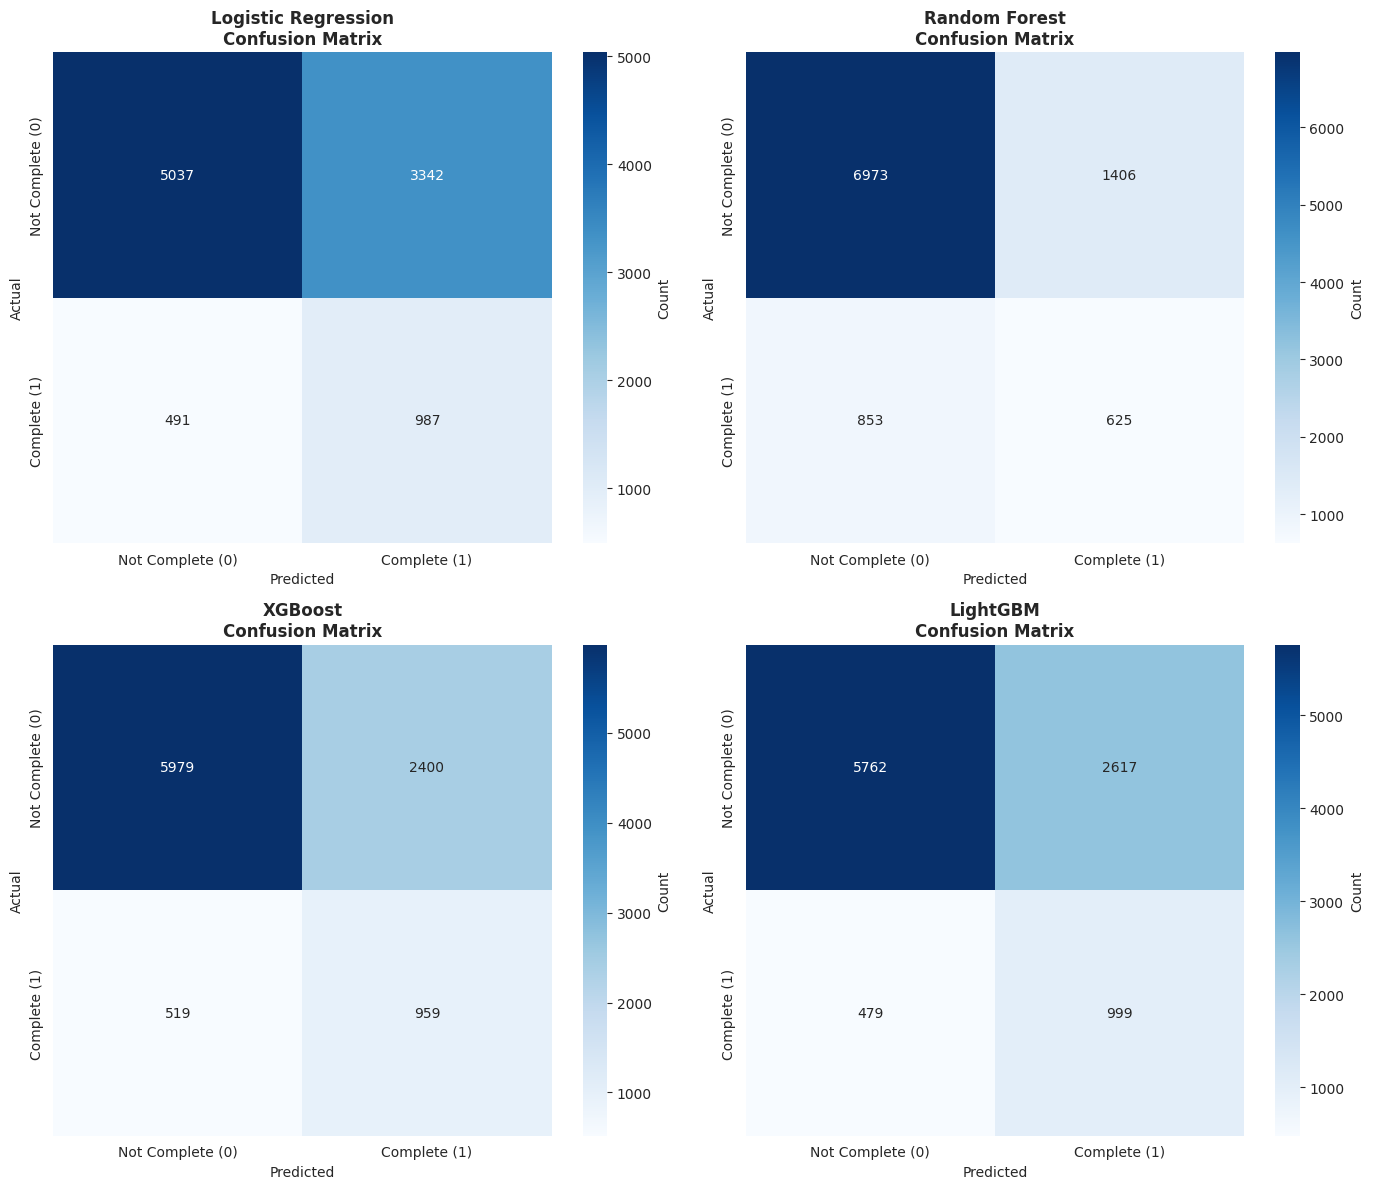

<Figure size 1200x600 with 0 Axes>

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

models_data = [
    ('Logistic Regression', y_pred_lr),
    ('Random Forest', y_pred_rf),
    ('XGBoost', y_pred_xgb),
    ('LightGBM', y_pred_lgb)
]

for idx, (model_name, y_pred) in enumerate(models_data):
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'{model_name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_xticklabels(['Not Complete (0)', 'Complete (1)'])
    axes[idx].set_yticklabels(['Not Complete (0)', 'Complete (1)'])

plt.tight_layout()
plt.show()
plt.savefig('images/02_Confusion_matrix_of_models.png', dpi=300, bbox_inches='tight')

>  Plot ROC curves

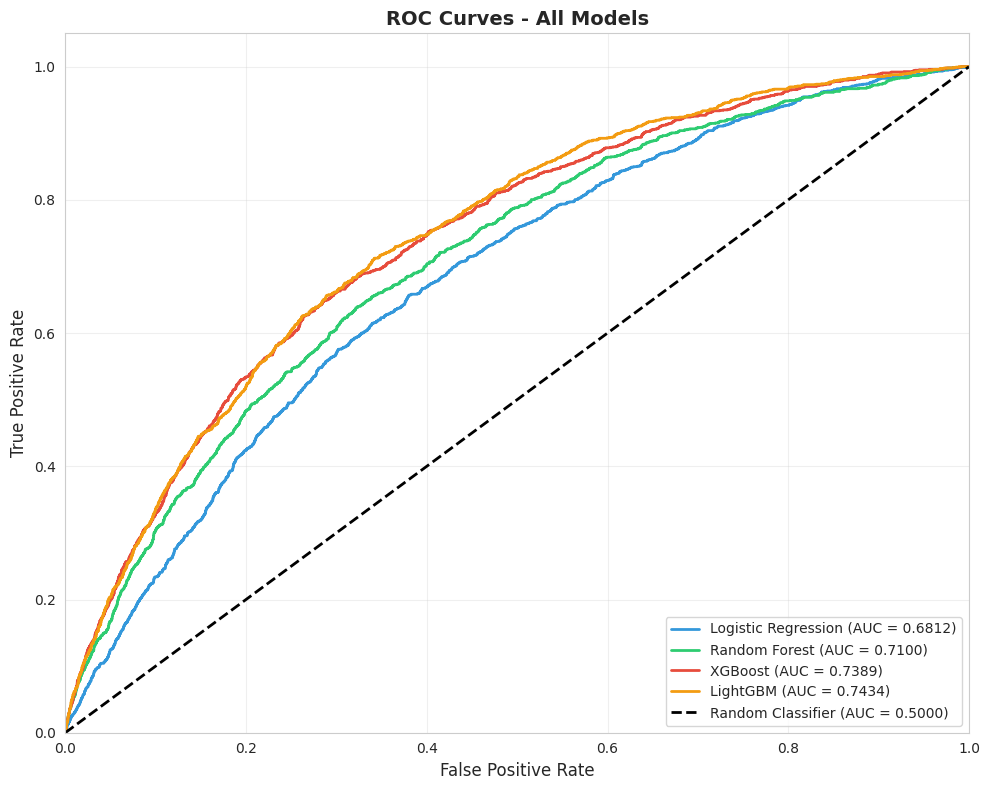

<Figure size 1200x600 with 0 Axes>

In [14]:
plt.figure(figsize=(10, 8))

models_proba = [
    ('Logistic Regression', y_pred_proba_lr),
    ('Random Forest', y_pred_proba_rf),
    ('XGBoost', y_pred_proba_xgb),
    ('LightGBM', y_pred_proba_lgb)
]

colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for idx, (model_name, y_pred_proba) in enumerate(models_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, color=colors[idx], lw=2,
             label=f'{model_name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5000)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('images/03_ROC_Curve.png', dpi=300, bbox_inches='tight')

> Plot Precision-Recall curves

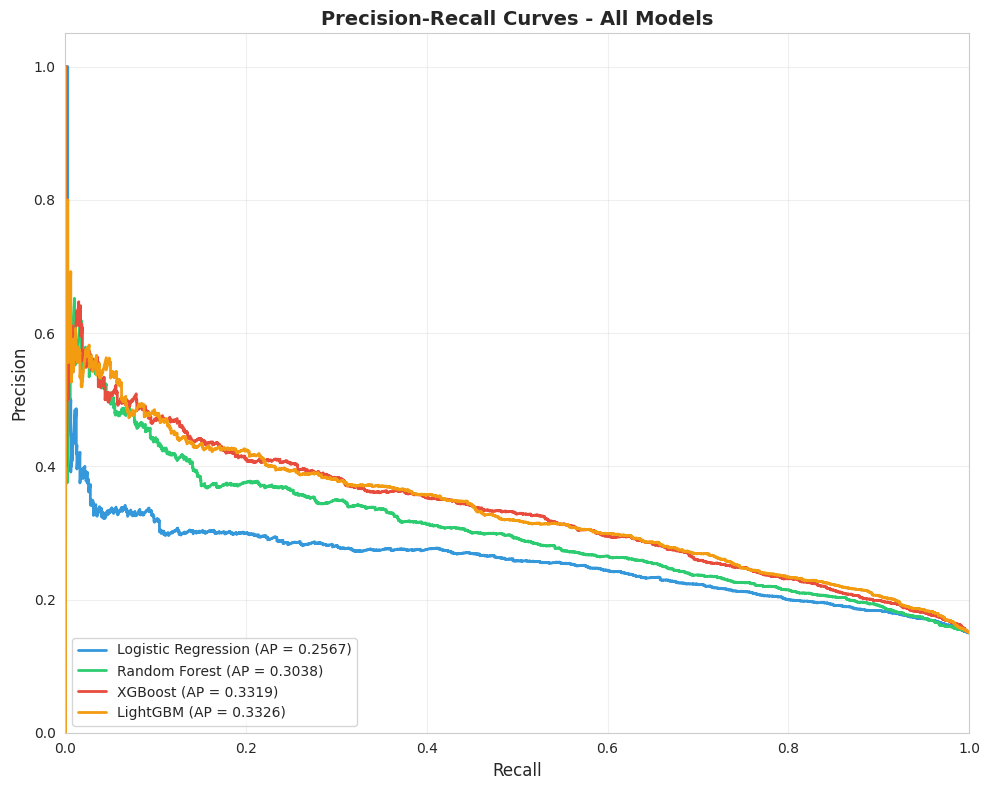

<Figure size 1200x600 with 0 Axes>

In [15]:
plt.figure(figsize=(10, 8))

for idx, (model_name, y_pred_proba) in enumerate(models_proba):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ap = average_precision_score(y_test, y_pred_proba)
    plt.plot(recall, precision, color=colors[idx], lw=2,
             label=f'{model_name} (AP = {ap:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('images/04_Precision_Recall_curve.png', dpi=300, bbox_inches='tight')

> Get feature importance from LightBGM

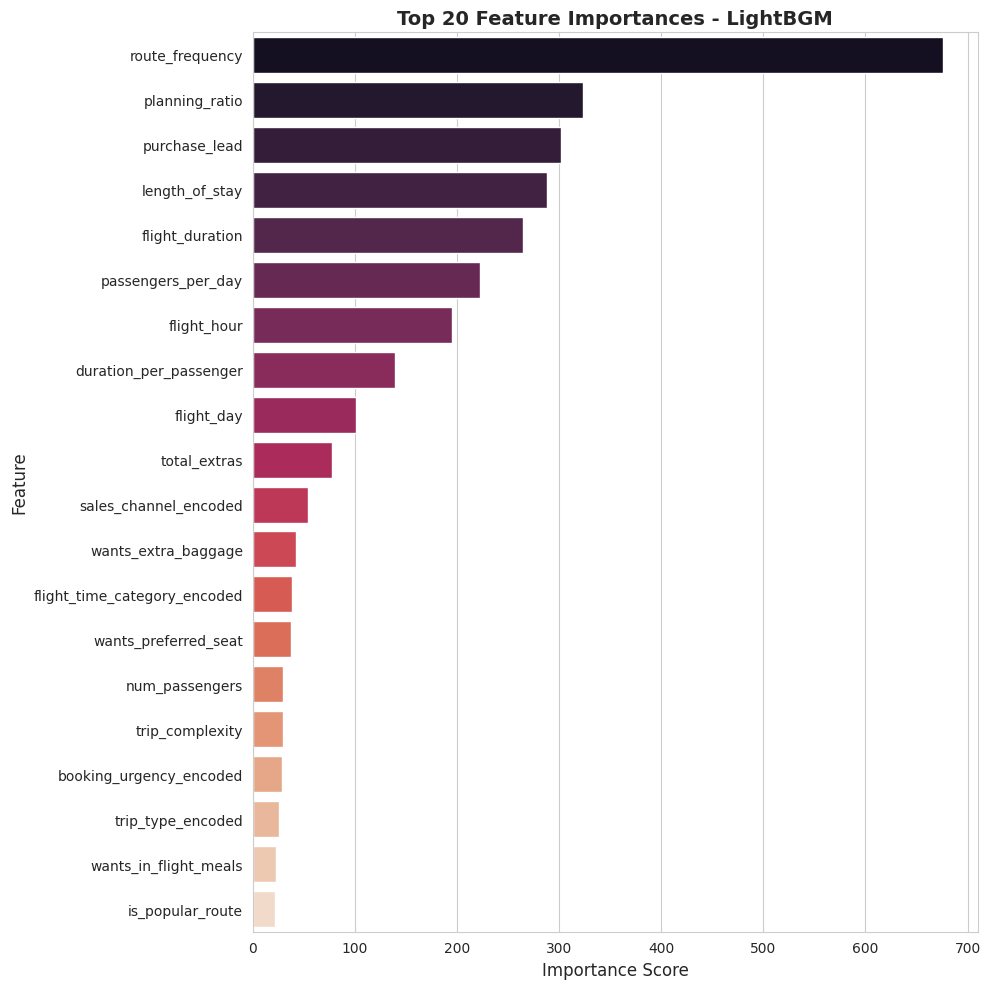


Top 15 Most Important Features (XGBoost):
                     Feature  Importance
             route_frequency         676
              planning_ratio         323
               purchase_lead         302
              length_of_stay         288
             flight_duration         265
          passengers_per_day         223
                 flight_hour         195
      duration_per_passenger         139
                  flight_day         101
                total_extras          78
       sales_channel_encoded          54
         wants_extra_baggage          42
flight_time_category_encoded          38
        wants_preferred_seat          37
              num_passengers          30


<Figure size 1200x600 with 0 Axes>

In [16]:
feature_importance_lgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 20 features
top_n = 20
plt.figure(figsize=(10, 10))
sns.barplot(data=feature_importance_lgb.head(top_n),
            y='Feature', x='Importance', palette='rocket')
plt.title(f'Top {top_n} Feature Importances - LightBGM',
          fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()
plt.savefig('images/05_top_features_lbg.png', dpi=300, bbox_inches='tight')

print("\nTop 15 Most Important Features (XGBoost):")
print("="*60)
print(feature_importance_lgb.head(15).to_string(index=False))


## Hyperparameter Tuning

> Let's Tune LightBGM

In [17]:
cv= StratifiedKFold(
    n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [18]:
param_dist = {
    'n_estimators': [100, 200,300,500,800],
    'learning_rate': [0.01, 0.03,0.05,0.1],
    'max_leaves': [15 ,31, 50, 100, 200],
    'max_depth': [-1, 1, 2, 4,6,8,10],
    'min_child_samples': [10, 20, 30, 40, 50,100],
    'subsample': [0.6,0.7,0.8, 0.9, 1.0],
    'colsample_bytree': [0.6,0.7,0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5,1.0],
    'reg_lambda': [0.0, 0.1, 0.5,1.0]
}

In [19]:
lgb_base=lgb.LGBMClassifier(
    objective='binary',
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    verbose=-1,
    n_jobs=-1

)

In [20]:
random_search= RandomizedSearchCV(
    estimator=lgb_base,
    param_distributions=param_dist,
    n_iter=40,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(n_jobs=-1, objective='binary',
                                            random_state=42,
                                            scale_pos_weight=np.float64(5.667343142228987),
                                            verbose=-1),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'max_depth': [-1, 1, 2, 4, 6, 8, 10],
                                        'max_leaves': [15, 31, 50, 100, 200],
                                        'min_child_samples': [10, 20, 30, 40,
                                                              50, 100],
                                        'n_estimators': [100, 200, 300, 500,
                                                         800],
                                        'reg_alpha': [0.0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0.0, 0.1, 0.5, 1.0],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [21]:
print("Best ROC-AUC: ", random_search.best_score_)
print("Best Parameters: ")
for k,v in random_search.best_params_.items():
    print(f"  {k}: {v}")

Best ROC-AUC:  0.7378097323712562
Best Parameters: 
  subsample: 0.8
  reg_lambda: 0.5
  reg_alpha: 1.0
  n_estimators: 300
  min_child_samples: 40
  max_leaves: 50
  max_depth: 8
  learning_rate: 0.03
  colsample_bytree: 0.7


In [22]:
best_lgb = random_search.best_estimator_
best_lgb.fit(X_train, y_train)


LGBMClassifier(colsample_bytree=0.7, learning_rate=0.03, max_depth=8,
               max_leaves=50, min_child_samples=40, n_estimators=300, n_jobs=-1,
               objective='binary', random_state=42, reg_alpha=1.0,
               reg_lambda=0.5, scale_pos_weight=np.float64(5.667343142228987),
               subsample=0.8, verbose=-1)

In [23]:
y_pred_best= best_lgb.predict(X_test)
y_prob_best = best_lgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_best))
print("ROC-AUC: ",roc_auc_score(y_test, y_prob_best))
print("PR-AUC: ",average_precision_score(y_test, y_prob_best))

              precision    recall  f1-score   support

           0       0.93      0.69      0.79      8379
           1       0.28      0.69      0.40      1478

    accuracy                           0.69      9857
   macro avg       0.60      0.69      0.59      9857
weighted avg       0.83      0.69      0.73      9857

ROC-AUC:  0.747641867087979
PR-AUC:  0.3351421143347136


## Save Models

In [24]:
best_name = "LightBGM"
best_model = best_lgb
best_score = roc_auc_score(y_test, y_prob_best)

with open('model/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f" Best Model: {best_name}")
print(f"  ROC-AUC: {best_score:.4f}")
print(f"  Saved: best_model.pkl")

all_models = {
    'lr': lr_model, 'rf': rf_model,
    'xgb': xgb_model, 'lgb': lgb_model
}

with open('model/all_models.pkl', 'wb') as f:
    pickle.dump(all_models, f)
print(" All models saved: all_models.pkl")

 Best Model: LightBGM
  ROC-AUC: 0.7476
  Saved: best_model.pkl
 All models saved: all_models.pkl
